## Environment set up and import Libraries

In [39]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [40]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
with tf.device(device_name):
  print(device_name.split(":")[1]," running . . . ")

GPU  running . . . 


In [41]:
import tensorflow as tf
import os,sys
import numpy as np
import random

random.seed(1)
np.random.seed(1)
tf.random.set_seed(2)

In [42]:
import os, keras, numpy,tensorflow
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from numpy import *
from numpy.random import *
from keras.datasets.fashion_mnist import load_data
from keras.datasets import mnist
from tensorflow.keras.optimizers import Adam
from keras.models import Model
from keras.layers import *
from tensorflow.keras import initializers

## **Discriminator** Model

In [43]:
def define_discriminator(in_shape=(64,64,3)):

    # input image
    input_image = Input(shape=in_shape)
    # (64, 64, 3)

    conv2d_layer_1 = Conv2D(filters = 16, kernel_size = (3,3), strides = (2,2), padding='same')(input_image)
    conv2d_layer_1 = LeakyReLU(alpha=0.3)(conv2d_layer_1)
    # (32, 32, 16)

    conv2d_layer_2 = Conv2D(filters = 32, kernel_size = (3,3), strides = (2,2), padding = 'same')(conv2d_layer_1)
    conv2d_layer_2 = LeakyReLU(alpha=0.3)(conv2d_layer_2)
    # (16, 16, 32)

    conv2d_layer_3 = Conv2D(filters = 64, kernel_size = (3,3),  strides = (2,2), padding = 'same')(conv2d_layer_2)
    conv2d_layer_3 = LeakyReLU(alpha=0.3)(conv2d_layer_3)
    # (8, 8, 64)

    conv2d_layer_4 = Conv2D(filters = 128, kernel_size = (3,3), strides = (2,2), padding = 'same')(conv2d_layer_3)
    conv2d_layer_4 = LeakyReLU(alpha=0.3)(conv2d_layer_4)
    # (4, 4, 128)

    flatten_layer = Flatten()(conv2d_layer_4)
    # (4 * 4 * 128)

    dropout_layer = Dropout(rate=0.4)(flatten_layer)
    # (4 * 4 * 128)

    dense_layer = Dense(128*8, activation='relu')(dropout_layer)
    # (8 * 128)

    # final layer
    output_layer = Dense(1, activation='sigmoid')(dense_layer)
    # (1,)

    model = Model(input_image, output_layer)

    opt = Adam(learning_rate= 3e-4, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

a = define_discriminator()
a.summary()

Model: "model_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 64, 64, 3)]       0         
                                                                 
 conv2d_40 (Conv2D)          (None, 32, 32, 16)        448       
                                                                 
 leaky_re_lu_34 (LeakyReLU)  (None, 32, 32, 16)        0         
                                                                 
 conv2d_41 (Conv2D)          (None, 16, 16, 32)        4640      
                                                                 
 leaky_re_lu_35 (LeakyReLU)  (None, 16, 16, 32)        0         
                                                                 
 conv2d_42 (Conv2D)          (None, 8, 8, 64)          18496     
                                                                 
 leaky_re_lu_36 (LeakyReLU)  (None, 8, 8, 64)          0  

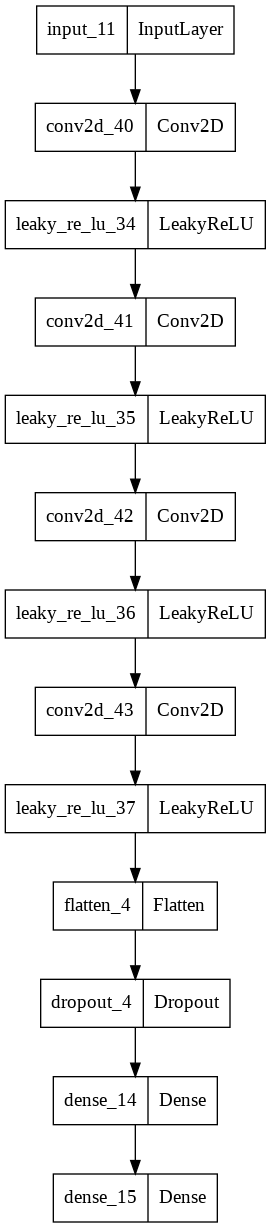

In [44]:
# plot the discriminator model
tf.keras.utils.plot_model(a)

## **Generator** Model

In [45]:
def define_generator(latent_dim = 100):

    # latent input
    latent_layer = Input(shape=(latent_dim,))

    layer_2 = Dense(128 * 8 * 8)(latent_layer)
    layer_2 = Activation("relu")(layer_2)
    layer_2 = Reshape((8, 8, 128))(layer_2)
    layer_2 = BatchNormalization(momentum = 0.8)(layer_2)


    # (8, 8, 128)

    layer_3 = Conv2DTranspose(filters = 128, kernel_size = (3,3), strides=(2,2), padding='same')(layer_2)
    layer_3 = Conv2D(filters = 128, kernel_size = (3,3), padding='same', kernel_initializer = initializers.RandomNormal(0,0.8))(layer_3)
    layer_3 = BatchNormalization(momentum = 0.8)(layer_3)
    layer_3 = LeakyReLU(alpha=0.4)(layer_3)
    # (16, 16, 128)

    layer_4 = Conv2DTranspose(filters = 128, kernel_size = (3,3), strides=(2,2), padding='same')(layer_3)
    layer_4 = Conv2D(filters = 128, kernel_size = (3,3), padding='same',kernel_initializer = initializers.RandomNormal(0,0.8))(layer_4)
    layer_4 = BatchNormalization(momentum = 0.8)(layer_4)
    layer_4 = LeakyReLU(alpha=0.4)(layer_4)
    # (32, 32, 128)

    layer_5 = Conv2DTranspose(filters = 256, kernel_size = (3,3), strides=(2,2), padding='same')(layer_4)
    layer_5 = Conv2D(filters = 256, kernel_size = (3,3), padding='same',kernel_initializer = initializers.RandomNormal(0,0.8))(layer_5)
    layer_5 = BatchNormalization(momentum = 0.8)(layer_5)
    layer_5 = LeakyReLU(alpha=0.4)(layer_5)
    # (64, 64, 128)

    # final layer
    output_layer = Conv2D(filters = 3, kernel_size = (3,3), strides=(1,1), activation='tanh', padding='same')(layer_5)

    model = Model(latent_layer, output_layer)
    return model

b = define_generator(100)
b.summary()

Model: "model_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 100)]             0         
                                                                 
 dense_16 (Dense)            (None, 8192)              827392    
                                                                 
 activation_6 (Activation)   (None, 8192)              0         
                                                                 
 reshape_6 (Reshape)         (None, 8, 8, 128)         0         
                                                                 
 batch_normalization_24 (Bat  (None, 8, 8, 128)        512       
 chNormalization)                                                
                                                                 
 conv2d_transpose_18 (Conv2D  (None, 16, 16, 128)      147584    
 Transpose)                                               

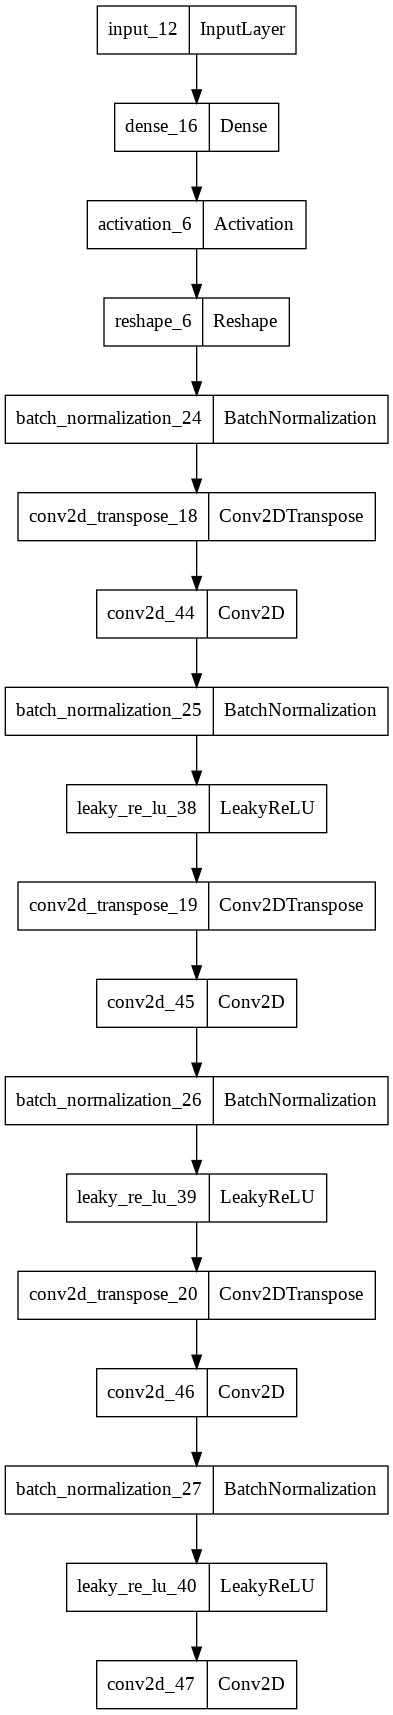

In [46]:
# plot the generator model
tf.keras.utils.plot_model(b)

## **Combine** or **GAN** Model

In [47]:
def define_gan(g_model, d_model):

  d_model.trainable = False

  g_noise = g_model.input
  g_output = g_model.output

  d_output = d_model(g_output)

  model = Model(g_noise, d_output)

  opt = Adam(learning_rate= 3e-4, beta_1=0.5)
  model.compile(loss='binary_crossentropy', optimizer=opt,  metrics=['accuracy'])
  
  return model
c = define_gan(b, a)
c.summary()

Model: "model_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 100)]             0         
                                                                 
 dense_16 (Dense)            (None, 8192)              827392    
                                                                 
 activation_6 (Activation)   (None, 8192)              0         
                                                                 
 reshape_6 (Reshape)         (None, 8, 8, 128)         0         
                                                                 
 batch_normalization_24 (Bat  (None, 8, 8, 128)        512       
 chNormalization)                                                
                                                                 
 conv2d_transpose_18 (Conv2D  (None, 16, 16, 128)      147584    
 Transpose)                                               

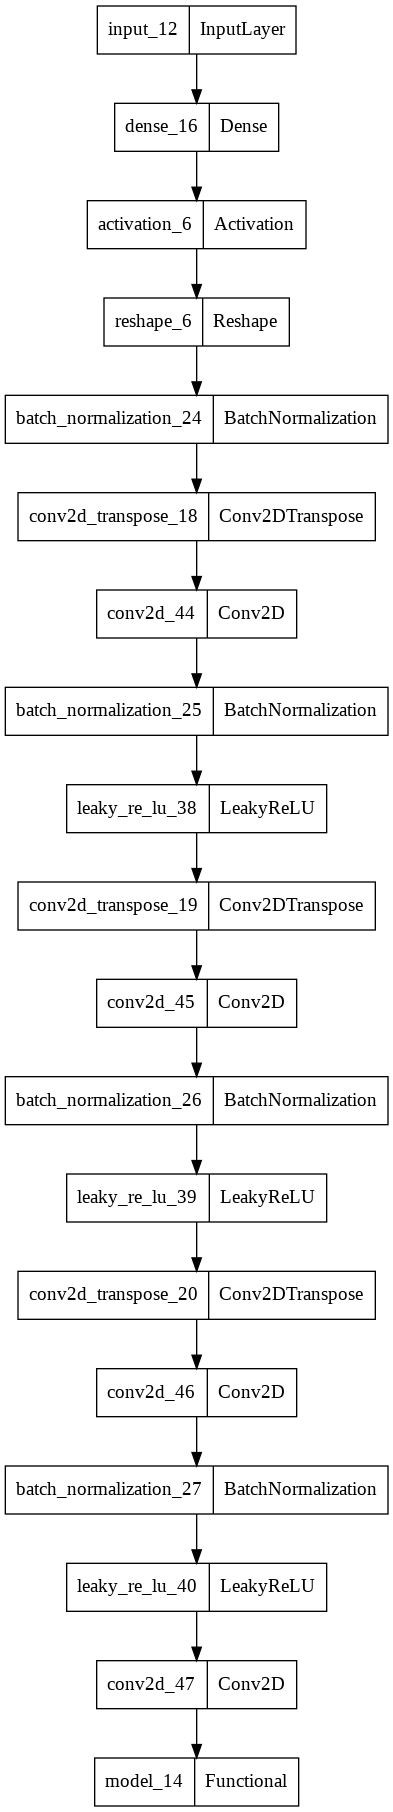

In [48]:
# plot GAN model
tf.keras.utils.plot_model(c)

## Load Dataset

In [49]:
def load_real_samples():
  # load dataset
  data = np.load("/content/drive/MyDrive/Animo/DataSet1/animo_file_10000.npz")
  data = data['a']
  data = np.array(data)
  X = data.astype('float32')
  # scale from [0,255] to [-1,1]
  X = (X - 127.5) / 127.5
  return X
k = load_real_samples()
print("image: ",k.shape)
print("\nshape/size of the first 16 data: ",k[:16].shape)

image:  (10000, 64, 64, 3)

shape/size of the first 16 data:  (16, 64, 64, 3)


## Plot data with label

## Plot data with label

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

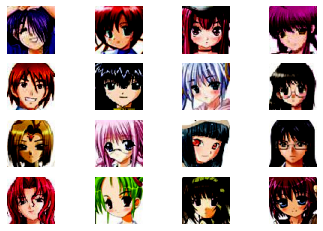

In [50]:
def save_plot(x_input,n=4):
    for i in range(n*n):
        plt.subplot(n, n, i+1)
        plt.imshow(x_input[i,:,:,:])
        plt.axis('off')
    plt.show()
# plot data
save_plot(k[:16])

## Generate real sample function

In [51]:
def generate_real_samples(dataset, n_samples):
	images = dataset
	ix = randint(0, images.shape[0], n_samples)
	X = images[ix]
	y = ones((n_samples, 1))
	return X, y
# d = generate_real_samples(k, 32)
# print("Generate real data as a batch randomly: ",d[0][0].shape)

## Generate latent point function

In [52]:
def generate_latent_points(latent_dim, n_samples, n_classes=2):
  x_input = randn(latent_dim * n_samples)
  z_input = x_input.reshape(n_samples, latent_dim)
  return z_input
# p = generate_latent_points(100, 32)
# print("Generate latent point(with label) as a batch: ",p.shape)

## Generate Fake samples of image with label

In [53]:
def generate_fake_samples(generator, latent_dim, n_samples):
	z_input = generate_latent_points(latent_dim, n_samples)
	images = generator.predict(z_input)
	y = zeros((n_samples, 1))
	return images, y
# with tf.device(device_name):
# 	kh = generate_fake_samples(b, 100, 32)
# 	print("shape of the generated images: ",kh[0].shape)

## Summarize the generator model

In [54]:
def summarize_the_model(generator,latent_dim = 100):
    latent_points = generate_latent_points(latent_dim= latent_dim, n_samples= 16)
    X  = generator.predict(latent_points)
    # scale from [-1,1] to [0,1]
    X = (X + 1) / 2.0
    save_plot(X, n=4)

## Train function

In [55]:
def train(g_model, d_model, gan_model, dataset, latent_dim= 100, n_epochs=3, n_batch=16):

  print("\nNo. of epoch: ",n_epochs)
  bat_per_epo = int(dataset.shape[0] / n_batch)
  print("\nbatch per epoch: ", bat_per_epo)
  half_batch = int(n_batch / 2)
  print("\nfull batch: ", n_batch)
  print("\nhalf batch: ", half_batch,'\n')
  print("*"*50,'\n\n')

  g_loss_array = []
  d_loss_array = []
  for i in range(n_epochs):
    d_loss = 0.0
    g_loss = 0.0
    
    for j in range(bat_per_epo):

      X_real, y_real = generate_real_samples(dataset, half_batch+1)
      X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch+1)
      X_actual_image = np.vstack((X_real,X_fake))
      X_actual_target = np.vstack((y_real,y_fake))
      d_loss_temp = 0.0
      for dk in range(1):
        x,_,y,_ = train_test_split(X_actual_image, X_actual_target, test_size=0.00001, random_state=42)
        d_loss_temp_1, _ = d_model.train_on_batch(x, y)
        d_loss_temp += d_loss_temp_1
      d_loss += (d_loss_temp/1.0)


      z_input = generate_latent_points(latent_dim, n_batch)
      y_gan = ones((n_batch, 1))
      g_loss1,_ = gan_model.train_on_batch(z_input, y_gan)
      g_loss += g_loss1

    d_loss_array.append(d_loss)
    g_loss_array.append(g_loss)

    print('epoch -> [%d/%d], discriminator_loss = %.2f, generator_loss = %.2f\n' %(i+1, n_epochs, d_loss, g_loss))
    summarize_the_model(g_model,latent_dim)
    g_model.save("/content/drive/MyDrive/Animo/DataSet1/generator_model.h5")
    np.savez_compressed("/content/drive/MyDrive/Animo/DataSet1/loss_record.npz", a=d_loss_array, b=g_loss_array)

    print("\n")

  return d_loss_array, g_loss_array

## Main function

In [56]:
with tf.device(device_name):

  latent_dim = 512
  n_epochs = 200
  n_batch = 32
  d_model = define_discriminator()
  g_model = define_generator(latent_dim)
  gan_model = define_gan(g_model, d_model)
  dataset = load_real_samples()
  print('\nREADY TO GO !!!\n')
  
  d_loss, g_loss = train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs, n_batch)

Output hidden; open in https://colab.research.google.com to view.

## Plot Loss Values

In [57]:
loaded = np.load('/content/drive/MyDrive/Animo/DataSet1/loss_record_11.npz')
print(loaded['a'].shape)
print(loaded['b'].shape)

(200,)
(200,)


In [58]:
import matplotlib.pyplot as plot

d_loss = np.array(loaded['a'])
g_loss = np.array(loaded['b'])

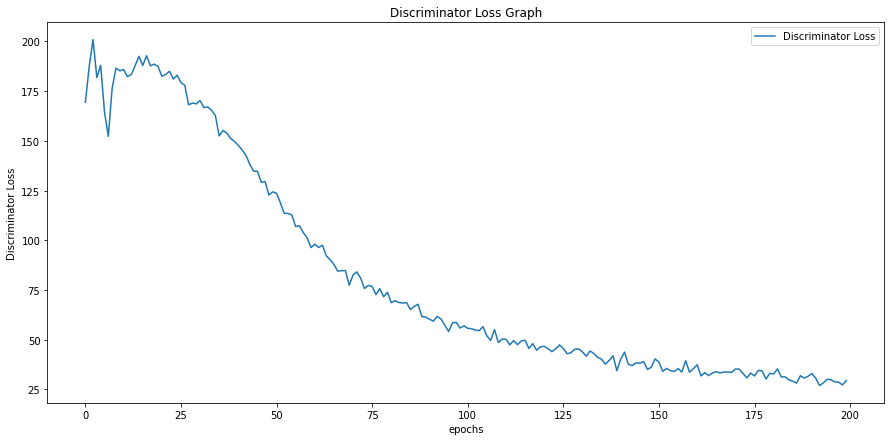

In [59]:
plt.figure(figsize=(15,7))
plt.plot(d_loss)
plt.title('Discriminator Loss Graph')
plt.ylabel('Discriminator Loss')
plt.xlabel('epochs')
plt.legend(["Discriminator Loss"], loc='upper right')
plt.show()

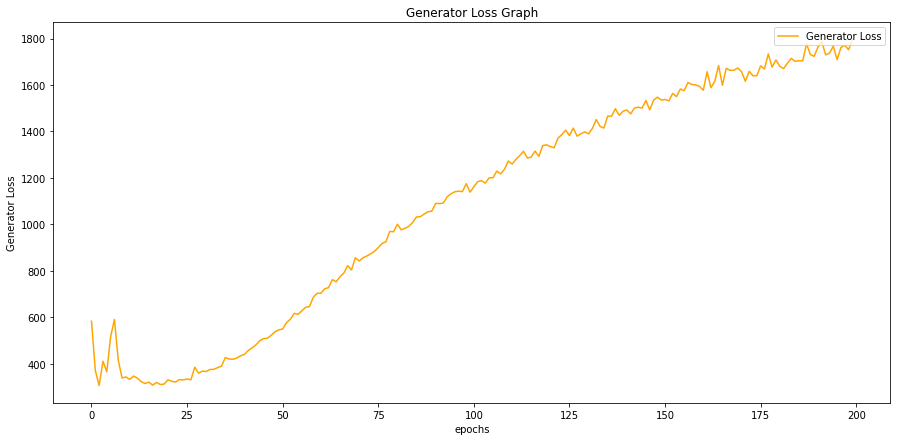

In [60]:
plt.figure(figsize=(15,7))
plt.plot(g_loss,color='orange')
plt.title('Generator Loss Graph')
plt.ylabel('Generator Loss')
plt.xlabel('epochs')
plt.legend(["Generator Loss"], loc='upper right')
plt.show()

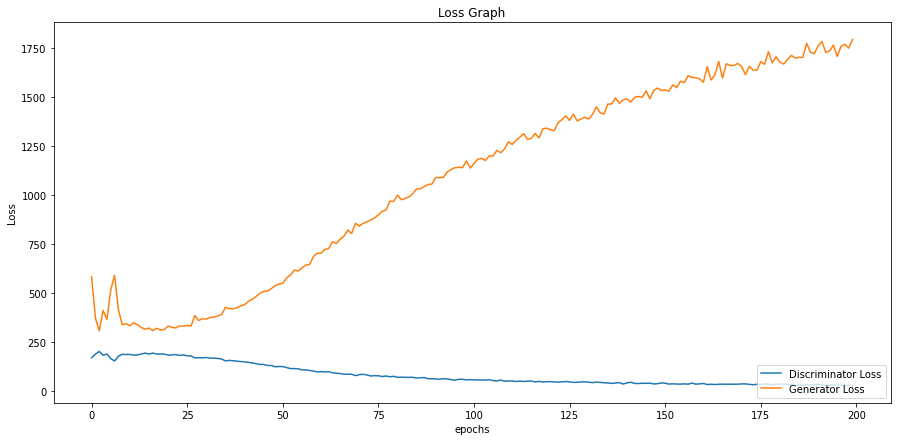

In [61]:
plt.figure(figsize=(15,7))
plt.plot(d_loss)
plt.plot(g_loss)
plt.title('Loss Graph')
plt.ylabel('Loss')
plt.xlabel('epochs')
plt.legend(["Discriminator Loss", "Generator Loss"], loc='lower right')
plt.show()

# Prediction

latent points(latent points):  (36, 512)

Generated images with labels:  (36, 64, 64, 3) 



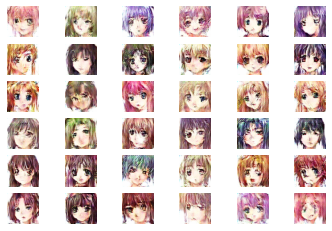

In [64]:
latent_dim = 512
n_samples = 36
z_input= generate_latent_points(latent_dim, n_samples)
print("latent points(latent points): ",z_input.shape)
data = z_input
g_model = tensorflow.keras.models.load_model("/content/drive/MyDrive/Animo/DataSet1/generator_model.h5")
pred = g_model.predict(data)
pred = (pred +1 ) / 2.0
print("\nGenerated images with labels: ",pred.shape,'\n')
save_plot(pred,n=6)

                                              -:END:-